In [230]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
import sys
import os
cwd = os.getcwd()
parent_directory = os.path.dirname(cwd)
sys.path.append(parent_directory)
import matplotlib.pyplot as plt

In [232]:
from pathlib import Path
from torchvision import transforms
from avalanche.benchmarks.classic import SplitCIFAR10, SplitMNIST
from continualUtils.models import PretrainedResNet18, SimpleMNISTCNN
import torch
from torch.utils.data import DataLoader
from captum.attr import Saliency
import numpy as np
from torchvision import datasets, transforms


In [233]:
class GetTransforms:
    """Returns a list of transformations when type as requested amongst train/test
    Transforms('train') = list of transforms to apply on training data
    Transforms('test') = list of transforms to apply on testing data"""

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = (
            [  # resises the image so it can be perfect for our model.
                # transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
                ),
            ]
        )

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
        return test_transforms

In [234]:
# transformations = GetTransforms()
# train_transforms = transforms.Compose(transformations.trainparams())
# test_transforms = transforms.Compose(transformations.testparams())

# dataset_path = Path.joinpath(Path("/mnt/datasets/"), "cifar10")
# benchmark = SplitCIFAR10(
#     n_experiences=1,
#     dataset_root=dataset_path,
#     # train_transform=train_transforms,
#     # eval_transform=test_transforms,
# )

# dataset_path = Path.joinpath(Path("/mnt/datasets/"), "mnist")
# benchmark = SplitMNIST(
#     n_experiences=1,
#     dataset_root=dataset_path,
# )

# train_stream = benchmark.train_stream[0]

In [235]:
transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())
dataset1 = datasets.CIFAR10('/mnt/datasets/cifar10/', train=True,
                    transform=train_transforms)
dataset2 = datasets.CIFAR10('/mnt/datasets/cifar10/', train=False,
                    transform=test_transforms)
trainloader = torch.utils.data.DataLoader(dataset1,batch_size=512, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False)

In [236]:
# Display image and label.
mb_x, mb_y= next(iter(trainloader))
print(f"Feature batch shape: {mb_x.size()}")
print(f"Labels batch shape: {mb_y.size()}")

Feature batch shape: torch.Size([512, 3, 32, 32])
Labels batch shape: torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


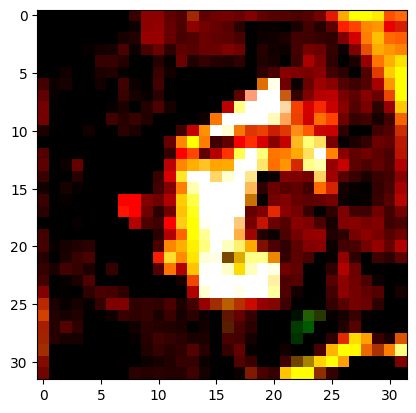

Label: 6


In [237]:
og_img = mb_x[0].squeeze()
label = mb_y[0]
# plt.figure(figsize=(2,2))
plt.imshow(og_img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

In [238]:
device = torch.device("cpu")
model = PretrainedResNet18(device=device)
# model = SimpleMNISTCNN(device=device, num_classes_per_task=10)

#### Original implementation

In [239]:
def get_SingleMask(percentage,fattr, remove_important=True,returnValues=False,Debug=False,numberOfFeatures=False):
    if(numberOfFeatures):
        k=percentage
    else:
        k = max(1, int(len(fattr)*len(fattr) * percentage))
    if(Debug):
        print("numberOfFeatures", k, "remove_important",remove_important)
    v, i = torch.topk(fattr.flatten(), k,largest=remove_important)
    mask = torch.zeros_like(fattr.flatten(), dtype=torch.bool)
    mask[i]=True
    mask= mask.reshape(fattr.shape)

    if(not returnValues):
        return mask
    else:
        return mask,v

In [240]:
def fill_SingleMask(input_image,mask,maskType="meanMask",customMask=None):
    channels = input_image.shape[0]
    num_masks = mask.sum()
    mask = mask.repeat(channels, 1, 1)

    if(maskType=="randomMask"):
        mean_input=[]
        for c in range(channels):
            min_channel=torch.min(input_image[c,:,:]).item()
            max_channel=torch.max(input_image[c,:,:]).item()
            randomMask = np.random.uniform(low=min_channel, high=max_channel,size=(num_masks,))
            mean_input.append(randomMask)
            input_image[c,mask[c]] = torch.FloatTensor(randomMask).to(device)
 
    else:
        if(maskType=="customMask"):
            mean_input=torch.Tensor(np.random.normal(0,1,input_image.mean([1, 2]).shape)).to(device)+customMask

        elif(maskType=="constantMask"):
            if(channels==3):
                mean_input=[customMask,customMask,customMask]
                mean_input=torch.FloatTensor(mean_input).to(device)
            else:
                mean_input=[customMask]
                mean_input=torch.FloatTensor(mean_input).to(device)
        elif(maskType=="trueMask"):
            mean_input = input_image[0,0,0]
        else:
            mean_input = input_image.mean([1, 2])
    
        input_image[mask] = mean_input.repeat(
            num_masks).reshape(num_masks, -1).T.flatten()
    return input_image

#### new implementation

In [241]:
def get_masks(num_masked_features, grads, noise=False):
        # Get batch size and number of channels
        batch, channels, *_ = grads.shape

        # Reshape grads for multi-channel processing
        grads_reshaped = grads.view(batch, channels, -1)

        # Get topk indices for each channel
        _, top_indices = torch.topk(
            grads_reshaped, num_masked_features, dim=2, largest=noise
        )

        # Initialize flat mask for each channel
        mask = torch.zeros_like(grads_reshaped, dtype=torch.bool)

        # Fill mask for each channel
        image_idx = torch.arange(batch).unsqueeze(1).unsqueeze(2)
        channel_idx = torch.arange(channels).unsqueeze(0).unsqueeze(2)
        mask[image_idx, channel_idx, top_indices] = True

        # Reshape mask to original grad shape
        mask = mask.reshape(grads.shape)

        return mask

def fill_masks(mb_x, mb_masks, noise=False):
    # Get input shape
    batch, channels, height, width = mb_x.shape

    # Expand mask if needed
    if mb_masks.shape[1] != channels:
        mb_masks = mb_masks.expand(batch, channels, height, width)

    if noise:
        noise_values = torch.rand_like(mb_x) * (2e-1) - 1e-1
        mb_x = torch.where(mb_masks, mb_x + noise_values, mb_x)
    else:
        # Get min and max for each channel, for each image
        min_vals = (
            mb_x.view(batch, channels, -1)
            .min(dim=2)[0]
            .unsqueeze(-1)
            .unsqueeze(-1)
        )
        max_vals = (
            mb_x.view(batch, channels, -1)
            .max(dim=2)[0]
            .unsqueeze(-1)
            .unsqueeze(-1)
        )

        # Build random values within range
        random_values = (
            torch.rand_like(mb_x) * (max_vals - min_vals)
        ) + min_vals

        # Replace with random values where indices are True
        mb_x = torch.where(
            condition=mb_masks, input=random_values, other=mb_x
        )

    return mb_x

In [242]:
features_dropped = 0.1

batch, channels, height, width = mb_x.shape
num_masked_features = int(features_dropped * height * width)

# Build saliency map
# Take mean
saliency_engine = Saliency(model)
grads = (
    saliency_engine.attribute(mb_x, mb_y, abs=False)
    # .mean(1)
    .detach()
    .to(dtype=torch.float)
)

# Clone images
temp_mb_x = mb_x.detach().clone()

##################################

# single_masks = get_masks(num_masked_features, grads.unsqueeze(1))
single_masks = get_masks(num_masked_features, grads)
temp_mb_x = fill_masks(mb_x, single_masks)

# for idx in range(batch):
#     singleMask = get_SingleMask(features_dropped, grads[idx], remove_important=False, Debug=False)
#     print(torch.equal(singleMask, single_masks[idx].squeeze(0)))
#     replacement = fill_SingleMask(temp_mb_x[idx], singleMask, "randomMask")
    
##################################


masked_input = temp_mb_x.view(mb_x.shape).detach()

In [243]:
differences = mb_x != masked_input
num_differences = differences.sum().item()
total_elements = mb_x.numel()
percentage_diff = (num_differences / total_elements) * 100
print(f"{percentage_diff}% different pixels")

9.9609375% different pixels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


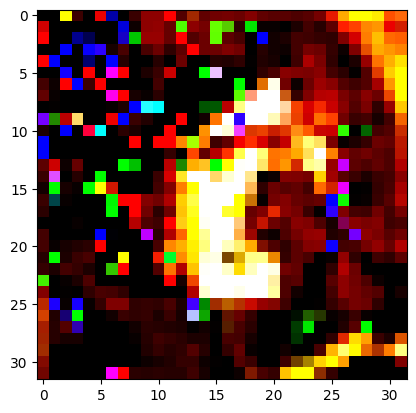

Label: 6


In [244]:
masked_img = masked_input[0].squeeze()
label = mb_y[0]
# plt.figure(figsize=(2,2))
plt.imshow(masked_img.T, cmap="gray")
plt.show()
print(f"Label: {label}")